In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import random

from sklearn.preprocessing import OneHotEncoder

## Data Collection and Preprocessing

1. Download the MovieLens and IMDb datasets.
2. Merge datasets to include movie ratings, genres, and metadata.

In [2]:
ratings_df = pd.read_csv('ml-1m/ratings.dat', sep='::', engine="python", header=None, names=['userId', 'movieId', 'rating', 'timestamp'])
movies_df = pd.read_csv('ml-1m/movies.dat', sep='::', engine="python", header=None, names=['movieId', 'movieName', 'Genre'], encoding='latin1')
users_df = pd.read_csv('ml-1m/users.dat', sep='::', engine="python", header=None, names=['userId', 'Sexe', 'Age', 'Occupation', 'ZipCode'])

In [3]:
display(ratings_df.head())
display(movies_df.head())
display(users_df.head())

,userId,movieId,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


,movieId,movieName,Genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


,userId,Sexe,Age,Occupation,ZipCode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


# Feature Engineering

1. Extract relevant features, you can choose the basic ones or create composite ones. A few examples are genres, diarectors, cast, and ratings.

In [4]:
# We only need the userID, movieId and rating / ZipCode is useless
ratings_df.drop(columns=["timestamp"], inplace=True)
users_df.drop(columns=["ZipCode"], inplace=True)

# Encoding genres of the movies
genre_encoder = OneHotEncoder()
genre_features = genre_encoder.fit_transform(movies_df[['Genre']]).toarray()

# Encodage des users informations
user_encoder = OneHotEncoder()
user_features = user_encoder.fit_transform(users_df[['Sexe', 'Age', 'Occupation']]).toarray()

print("User Features:\n", user_features)
print("\nGenre Featuers:\n", genre_features)

User Features:
 [[1. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]

Genre Featuers:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


2. Create a user-item interaction matrix for collaborative filtering.

3. Understand how to combine user data to get data for the couple of users.

In [5]:
# 2. User-item matrix 
matrix_df = ratings_df.pivot(index="userId", columns="movieId", values="rating").fillna(0)
display(matrix_df.head())

# 3. Combine user data to have couple of users
print("Check Method 2 Fusion User on the Model Development part about how we can combine user data")

# Preprocessing in order to do matrix Factorization
def normalizeRatings(Y: np.ndarray, R: np.ndarray, axis: int = 1):
    Ymean = (np.sum(Y * R, axis=axis) / (np.sum(R, axis=axis) + 1e-12)).reshape(-1, 1)
    Ynorm = Y.T - np.multiply(Ymean, R.T)
    return Ynorm

def split_ratings(Y, R, user_features):
    return Y[1000:], Y[:1000], user_features[1000:], R[1000:]
    
Y = matrix_df.to_numpy()
R = np.where(Y != 0, 1, 0)

movieId,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
userId,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Check Method 2 Fusion User on the Model Development part about how we can combine user data


# Model Development

Implement a recommender system algorithm to predict the rating of a movie by a couple of users.

The recommender system algorithm we will use is the : Matrix Factorization Algorithm. In a first place, we will do a simple Matrix Factorization based on a Funk SVD that will predict a score when we link a user to a movie

In [82]:
class FunkSVD:
    def __init__(self, latent_dim: int, movie_features: np.ndarray, user_features: np.ndarray):
        self.latent_dim = latent_dim
        self.movie_features = movie_features
        self.user_features = user_features
        self.hist = {}

    def fit(self, ratings, r_mask, n_users, n_items, max_iter, learning_rate: 1.0e-5):
        user_mat = np.random.rand(n_users, self.latent_dim + self.user_features.shape[1])
        item_mat = np.random.rand(self.latent_dim + 30 , n_items)
        
        user_mat[:, :self.user_features.shape[1]] = self.user_features
        # item_mat[:self.movie_features.shape[1], :] = self.movie_features.T
        
        self.hist["mse"] = []
        for _ in range(max_iter):
            mask = r_mask > 0
            diff_mat = ratings - np.dot(user_mat, item_mat).T
            n_ratings = len(diff_mat)
            diff_mat /= n_ratings
            mse = np.sum(np.square(diff_mat[mask]))
            self.hist["mse"].append(mse)
            user_mat += learning_rate * np.dot(item_mat, diff_mat).T
            item_mat += learning_rate * np.dot(diff_mat, user_mat).T

        self.mse_ = mse
        self.user_mat_ = user_mat
        self.item_mat_ = item_mat

        print(f"Training complete.\nMean squared error: {self.mse_:.3f}")

    def predict_rating(self, user_id, item_id):
        return np.dot(self.user_mat_[user_id - 1, :], self.item_mat_[:, item_id - 1]) / 2

### How can we predict for a couple ?

We have an algorithm that can predict a score for a user-movie pair. Now, our goal is to predict a score for a couple of users and a movie. Here are two methods to achieve this:

#### Method 1: Average of Individual Ratings
- Approach: Calculate the predicted rating for a movie by taking the average of the ratings given by the two users in the couple.
    
#### Method 2: Fusion of Users
- Approach: Create a new user profile that combines the preferences of both users in the couple.

In [7]:
def predict_couples_m1(userId1, userId2, movieId, model : FunkSVD):
    score1 = model.predict_rating(userId1, movieId)
    score2 = model.predict_rating(userId2, movieId)
    return (score1 + score2) / 2

In [73]:
def predict_couples_m2(userId1, userId2, movieId, model : FunkSVD):
    user1 = model.user_mat_[userId1 - 1, :]
    user2 = model.user_mat_[userId2 - 1, :]
    average_user = (user1 + user2) / 2
    score = np.dot(average_user, model.item_mat_[:, movieId - 1]) / 4
    return score

# Recommendation Algorithm

1. Develop an algorithm to suggest one movie that might be liked by the couple of users. You can use the criteria you prefer to create a "couple score" for each movie and then sort the movies by the score.

We already have a function that predicts a score for a movie based on the preferences of a couple of users. With approximately 4000 movies, we plan to loop through all movies, compute scores, and return the top 10 recommendations. However, for datasets with many more movies, it may become impractical to check every movie. In such cases, we propose taking a subset of movies and applying the same prediction function.




Here are 3 algorithms depending on the preferences of the couple:

#### Algorithm 1: Match a Movie (Including Seen Movies)
- Objective: Recommend movies that match the couple's preferences, regardless of whether both have already seen the movie.

#### Algorithm 2: Exclude Movies Seen by at least One Member
- Objective: Recommend movies that at least one member of the couple has not seen before.

#### Algorithm 3: Exclude Movies Seen by Both Members
- Objective: Recommend movies that neither member of the couple has seen before.

In [94]:
def reduce_set(l):
    return list(filter(lambda x: x <= 3700, l))

def convert_id_to_movies(top_movies, movies_df):
    top_movies_with_titles = []
    for movieId, score in top_movies:
        movie_title = movies_df.loc[movies_df['movieId'] == movieId, 'movieName'].values[0]
        top_movies_with_titles.append((movie_title, score))
    return top_movies_with_titles

def couples_recommendation_algorithm(userId1, userId2, model, n_items, movies_df):
    result = {}
    for i in range(n_items):
        result[i] = predict_couples_m1(userId1, userId2, i, model)  

    sorted_items = sorted(result.items(), key=lambda x: x[1], reverse=True)
    return convert_id_to_movies(sorted_items[:10], movies_df)

def couples_recommendation_algorithm_2(userId1, userId2, model, movies_df):
    result = {}
    not_seen_by_user1 = set(matrix_df.columns[matrix_df.iloc[user1 - 1] == 0])
    not_seen_by_user2 = set(matrix_df.columns[matrix_df.iloc[user2 - 1] == 0])
    not_seen_by_either = reduce_set(list(not_seen_by_user1.union(not_seen_by_user2)))

    for movieId in not_seen_by_either:
        result[movieId] = predict_couples_m2(userId1, userId2, movieId, model) 
        
    sorted_items = sorted(result.items(), key=lambda x: x[1], reverse=True)
    return convert_id_to_movies(sorted_items[:10], movies_df)

def couples_recommendation_algorithm_3(userId1, userId2, model, matrix_df, movies_df):
    result = {}    
    not_seen_by_user1 = set(matrix_df.columns[matrix_df.iloc[user1 - 1] == 0])
    not_seen_by_user2 = set(matrix_df.columns[matrix_df.iloc[user2 - 1] == 0])
    not_seen_by_either = reduce_set(list(not_seen_by_user1.union(not_seen_by_user2)))
    
    for movieId in not_seen_by_both:
        result[movieId] = predict_couples_m1(userId1, userId2, movieId, model)

    sorted_items = sorted(result.items(), key=lambda x: x[1], reverse=True)
    return convert_id_to_movies(sorted_items[:10], movies_df)

# Evaluation

1. Split the data into training and testing sets.

In [11]:
Y_train, Y_val, users_features_train, R_train = split_ratings(Y,R, user_features)
Y_norm = normalizeRatings(Y_train, R_train, axis=0)
n_users, n_items = Y_train.shape
funk_model = FunkSVD(latent_dim=120, movie_features=genre_features, user_features=users_features_train)
funk_model.fit(Y_norm, R_train.T, n_users, n_items, max_iter=300, learning_rate=1.0e-4)

Training complete.
Mean squared error: 3.628


2. Evaluate the model, choose the metric you prefer.

For user 1 and movie 1 Real rating is 5.0                       predicted rating is 4.85.
For user 1 and movie 6 Real rating is 4.0                       predicted rating is 4.49.
For user 1 and movie 8 Real rating is 4.0                       predicted rating is 4.82.
For user 1 and movie 9 Real rating is 5.0                       predicted rating is 4.19.
For user 1 and movie 10 Real rating is 5.0                       predicted rating is 4.73.
For user 1 and movie 18 Real rating is 4.0                       predicted rating is 4.18.
For user 1 and movie 19 Real rating is 5.0                       predicted rating is 4.36.
For user 1 and movie 21 Real rating is 3.0                       predicted rating is 3.91.
For user 1 and movie 23 Real rating is 4.0                       predicted rating is 4.09.
For user 1 and movie 26 Real rating is 3.0                       predicted rating is 3.41.


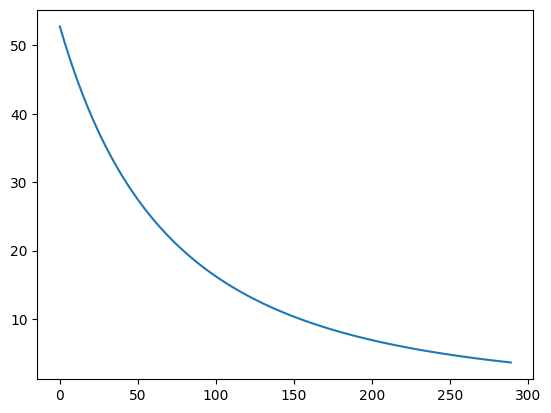

In [17]:
def validation_print(Y_val: np.ndarray, model: FunkSVD, num_prints: int = 10) -> None:
    rows, cols = np.nonzero(Y_val.T)
    for k in range(num_prints):
        pred = float(model.predict_rating(rows[k] + 1, cols[k] + 1))
        rating = Y_val.T[rows[k], cols[k]]
        print(f"For user {rows[k]+1} and movie {cols[k]+1} Real rating is {rating:<25} predicted rating is {pred:.2f}.")

plt.plot(funk_model.hist["mse"][10:])
validation_print(Y_val, funk_model, num_prints=10)

In [21]:
 def evaluate(Y_val, model):
    rows, cols = np.nonzero(Y_val.T)
    result = 0
    for k in range(Y_val.shape[0]):
        pred = float(model.predict_rating(rows[k] + 1, cols[k] + 1))
        rating = Y_val.T[rows[k], cols[k]]
        result += (pred - rating)** 2
    
    return (result / Y_val.shape[0])

rmse_metrics = evaluate(Y_val, funk_model)
print("Metrics RMSE on val test", rmse_metrics)

Metrics RMSE on val test 1.300334184242114


In [97]:
# Change according to which user you want
user1 = 40
user2 = 86

# With Algo 1 and Prediction Method 1
i = 1
top_10_movies_with_titles = couples_recommendation_algorithm(user1, user2, funk_model, n_items, movies_df)
for movie_title, score in top_10_movies_with_titles:
    print(f"Movie {i}: {movie_title}")
    i += 1
print("\n")

user1 = 786
user2 = 12
# With Algo 2 and Prediction Method 
i = 1
top_10_movies_with_titles = couples_recommendation_algorithm_2(user1,user2, funk_model, movies_df)
for movie_title, score in top_10_movies_with_titles:
    print(f"Movie {i}: {movie_title}")
    i += 1

Movie 1: Blood, Guts, Bullets and Octane (1998)
Movie 2: Muppet Christmas Carol, The (1992)
Movie 3: Other Sister, The (1999)
Movie 4: Police Academy 5: Assignment: Miami Beach (1988)
Movie 5: Tommy Boy (1995)
Movie 6: Disclosure (1994)
Movie 7: Autopsy (Macchie Solari) (1975)
Movie 8: Rescuers, The (1977)
Movie 9: Angela's Ashes (1999)
Movie 10: Down Periscope (1996)


Movie 1: Prom Night (1980)
Movie 2: I Dreamed of Africa (2000)
Movie 3: Something Wicked This Way Comes (1983)
Movie 4: My Life in Pink (Ma vie en rose) (1997)
Movie 5: Little City (1998)
Movie 6: Citizen Kane (1941)
Movie 7: Tex (1982)
Movie 8: Dersu Uzala (1974)
Movie 9: Perfect Candidate, A (1996)
Movie 10: Immortal Beloved (1994)
